In [1]:
import pandas as pd
from datetime import datetime
import shapefile
import csv
import numpy as np
from __future__ import division
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import train_test_split
from patsy import dmatrices

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import auc

import pickle
from sklearn.multiclass import OneVsRestClassifier
from sklearn import preprocessing as prp
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from time import time
from sklearn.linear_model import Perceptron
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier

### Load data

In [2]:
with open('full_data.pkl','r') as f:
    df = pickle.load(f)

In [3]:
# full dataset: df

# only subscribers have gender and birth year information
# subset to include those features, and disregard birth years before 1915
df_sub = df[(df['birth_year']>1915.0) & (df['usertype']=='Subscriber') 
                 & (df['gender']!=0)& (df['tripduration']<=3600)]  

print len(df)
print len(df_sub)

876785
849168


### Split data into features and response variable

In [4]:
def assign_train_test(df_any, sub = False):
    '''Assign y and X. 
    Dummify categorical variables (neighborhood, weekday, gender).
    Standardize continuous variables.
    Returns train and test subsets'''
    
    # response variable is destination neighborhood
    y = df_any['n2']
    
    # features depend on whether analysis on all data or subscriber data
    if sub==True:
        cols_n = ['tripduration','birth_year','starttime_time','docks_y'] # features to Standardize
        cols_c = ['n1','gender','day_start'] # categorical features
    else:
        cols_n = ['tripduration','starttime_time','docks_y'] # features to Standardize
        cols_c = ['n1','day_start','usertype'] # categorical features. include usertype as feature
    
    X = df_any[cols_n + cols_c]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
    
    scaler = StandardScaler() # Standardize continuous variables
    scaler.fit(X_train[cols_n]) # Fit standardization rule to training data
        
    # continous variable treatment
    X_train_1 = pd.DataFrame(scaler.transform(X_train[cols_n]), columns=cols_n)
    X_test_1 = pd.DataFrame(scaler.transform(X_test[cols_n]), columns=cols_n)
    
    # categorical variables
    X_train_2 = pd.get_dummies(X_train[cols_c], columns = cols_c)
    X_test_2 = pd.get_dummies(X_test[cols_c], columns = cols_c)
    
    # bring 'em together
    X_train = pd.concat((X_train_1.reset_index(drop=True),X_train_2.reset_index(drop=True)),1)
    X_test = pd.concat((X_test_1.reset_index(drop=True),X_test_2.reset_index(drop=True)),1)
    
    return X_train, X_test, y_train, y_test

In [5]:
X_train, X_test, y_train, y_test = assign_train_test(df_sub, sub = True)

In [6]:
X_test.head()

,tripduration,birth_year,starttime_time,docks_y,n1_Battery Park City,n1_Bedford-Stuyvesant,n1_Boerum Hill,n1_Brooklyn Heights,n1_Central Park,n1_Chelsea,...,n1_Williamsburg,gender_1,gender_2,day_start_Friday,day_start_Monday,day_start_Saturday,day_start_Sunday,day_start_Thursday,day_start_Tuesday,day_start_Wednesday
0,-0.087249,0.246179,0.211973,2.684895,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,-0.311672,0.159928,0.408855,-1.410908,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
2,-0.679343,0.504932,-0.015459,0.078475,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
3,2.715650,-0.702584,-1.128860,-0.293871,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
4,2.789662,0.504932,-0.633261,-0.666216,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [12]:
# Function to fit model, print training time and prediction time, 
# then print accuracy and classification report

def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train) # fit model
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test) # predict 
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred) # accuracy
    print("accuracy:   %0.3f" % score)
    
    prec, rec, f1, _ = precision_recall_fscore_support(y_test,pred, average = 'weighted')
    
    clf_descr = str(clf).split('(')[0] # string name of classifier
    return clf_descr, score, prec, rec, f1

In [95]:
# SELECTING COLUMNS
# X_1 = X_test.ix[:,4:]

In [15]:
# Models to use
# Perceptron is the same as Stochastic Gradient Descent with certain parameters:
# SGDClassifier(loss=”perceptron”, eta0=1, learning_rate=”constant”, penalty=None)

for clf, name in (
        (DecisionTreeClassifier(class_weight='auto', max_features = 'auto'), "Decision Tree"),
        (RandomForestClassifier(n_estimators = 10, n_jobs = -1, class_weight='auto'), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

Decision Tree
________________________________________________________________________________
Training: 
DecisionTreeClassifier(class_weight='auto', criterion='gini', max_depth=None,
            max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')
train time: 21.216s
test time:  1.533s
accuracy:   0.510
Random forest
________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, class_weight='auto', criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
train time: 144.080s
test time:  330.552s
accuracy:   0.584


In [35]:
results = []

# Models to use
# Perceptron is the same as Stochastic Gradient Descent with certain parameters:
# SGDClassifier(loss=”perceptron”, eta0=1, learning_rate=”constant”, penalty=None)

for clf, name in (
        (DecisionTreeClassifier(class_weight='auto'), "Decision Tree"),
        (Perceptron(n_jobs = -1, n_iter = 5, class_weight = 'auto'), "Perceptron"),
        (LogisticRegression(multi_class = 'multinomial',solver = 'lbfgs', 
                            class_weight = 'auto'), "Logistic"),
        (RandomForestClassifier(n_estimators = 5), "Random forest"),
        (SGDClassifier(class_weight = 'auto', n_jobs = -1, random_state = 1, loss = 'log'), 
         "Stochastic Gradient Descent")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
results.append(benchmark(Pipeline([
  ('feature_selection', LinearSVC(penalty = 'l1',dual=False, tol=1e-3, fit_intercept = False, class_weight = 'auto')),
  ('classification', RandomForestClassifier(n_estimators = 5))
])))

Decision Tree
________________________________________________________________________________
Training: 
DecisionTreeClassifier(class_weight='auto', criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')
train time: 27.583s
test time:  0.392s
accuracy:   0.584
Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight='auto', eta0=1.0, fit_intercept=False,
      n_iter=5, n_jobs=-1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)
train time: 12.495s
test time:  0.217s
accuracy:   0.075
Logistic
________________________________________________________________________________
Training: 
LogisticRegression(C=1.0, class_weight='auto', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_cl

In [37]:
clf = AdaBoostClassifier(
    DecisionTreeClassifier(class_weight='auto'),
    n_estimators=30,
    learning_rate=1, random_state = 1)
results.append(benchmark(clf))

________________________________________________________________________________
Training: 
AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='auto', criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best'),
          learning_rate=1, n_estimators=30, random_state=1)
train time: 857.223s
test time:  27.605s
accuracy:   0.593


In [38]:
clf = AdaBoostClassifier(
    DecisionTreeClassifier(class_weight='auto',max_features = 'auto'),
    n_estimators=50,
    learning_rate=1.5, random_state = 1)
results.append(benchmark(clf))

________________________________________________________________________________
Training: 
AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='auto', criterion='gini', max_depth=None,
            max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best'),
          learning_rate=1.5, n_estimators=50, random_state=1)
train time: 360.407s
test time:  1213.421s
accuracy:   0.018


/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
models = {'logistic': LogisticRegression(multi_class = 'multinomial',solver = 'lbfgs', class_weight = 'auto'),
          'rf': RandomForestClassifier(n_estimators=5, class_weight='auto', n_jobs = -1, random_state = 1),
          'tree': DecisionTreeClassifier(class_weight='auto'),
            'gnb': GaussianNB()}

for name,model in models.iteritems():
    m = model.fit(X_train,y_train)
    preds = m.predict(X_test)
    print "\n {0}".format(name)
    print "prec: {d[0]:.6f}, rec: {d[1]:.6f}, f1: {d[2]:.6f} (micro)".format(d=precision_recall_fscore_support(y_test, 
                                                                                  preds, average = 'micro'))
    print "prec: {d[0]:.6f}, rec: {d[1]:.6f}, f1: {d[2]:.6f} (weighted)".format(d=precision_recall_fscore_support(y_test, 
                                                                            preds, average = 'weighted'))


 gnb
prec: 0.015826, rec: 0.015826, f1: 0.015826 (micro)
prec: 0.027397, rec: 0.015826, f1: 0.004575 (weighted)

 rf
prec: 0.473841, rec: 0.473841, f1: 0.473841 (micro)
prec: 0.489542, rec: 0.473841, f1: 0.468079 (weighted)

 tree
prec: 0.589640, rec: 0.589640, f1: 0.589640 (micro)
prec: 0.589415, rec: 0.589640, f1: 0.589478 (weighted)

In [119]:
fpr = dict()
tpr = dict()
roc_auc = dict()
bin_y = pd.get_dummies(y_test)
for i in range(37):
    fpr[i], tpr[i], _ = roc_curve(np.array(bin_y)[:, i], m.predict_proba(X_test)[:,i]) 
    # find prediction rates for each class
    roc_auc[i] = auc(fpr[i], tpr[i])

In [118]:
m.predict_proba(X_test).shape

(95036, 37)

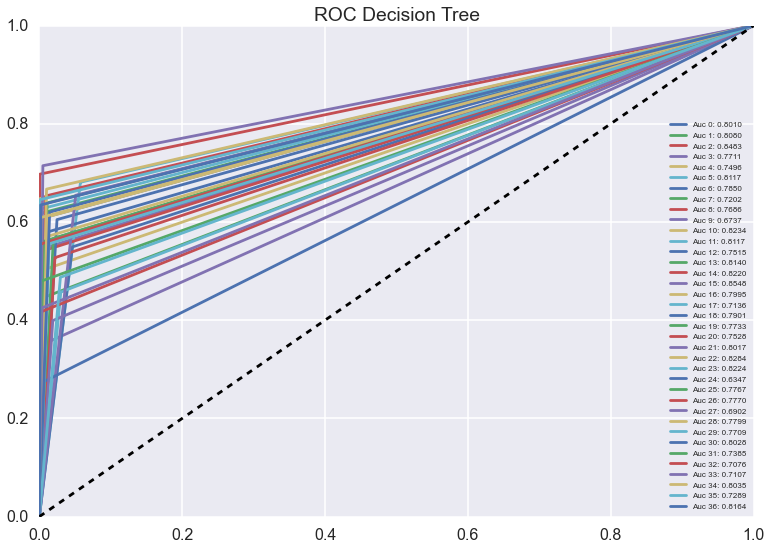

In [124]:
plt.figure(figsize=(12, 10))
fig, ax = plt.subplots()
sns.set_style("darkgrid")
sns.set_context(context="poster")
for i in range(37):
    ax.plot(fpr[i],tpr[i],label="Auc {0}: {1:0.4f}".format(i,roc_auc[i]))
ax.plot([0, 1], [0, 1], 'k--')
ax.legend(loc="best", fontsize=8)
plt.title("ROC: {0}".format("Decision Tree"))

In [ ]:
models = {'logistic': LogisticRegression(),
          'rf': RandomForestClassifier(n_estimators=100),
          'svc': SVC(probability=True),
          'tree': DecisionTreeClassifier()}

fpr = dict()
tpr = dict()
roc_auc = dict()

for name,model in models.iteritems():
    model.fit(X_train, y_train)
    fpr[name], tpr[name], _ = roc_curve(np.array(y_test),model.predict_proba(X_test)[:,1]) 
    #true and false positive rates
    roc_auc[name] = auc(fpr[name], tpr[name]) #auc score for each model
    print roc_auc

In [15]:
def tfun(x):
    print 'hey {0}'.format(x)
    print 'what'
    
results = []
results.append(tfun('claire'))

hey claire
what


In [17]:
clf = GaussianNB()
clf_descr = str(clf).split('(')[0]

In [18]:
clf_descr

'GaussianNB'